In [35]:
using PlotlyJS
using Parquet2: writefile, Dataset

include("../model/utils.jl")
include("../model/unit_commitment.jl")
include("../model/economic_dispatch.jl")
include("./plotting.jl")
include("./processing.jl")
mip_gap = 0.0001
reserve_margin = 0.1
min_reserve = 0

0

In [2]:

max_iterations = 10
ed_config = Dict(:max_iterations => max_iterations)
days = [15, 45]
configurations =  [:base_ramp_storage_reserve, :base_ramp_storage_envelopes, :base_ramp_storage_energy_reserve_cumulated]
;

In [3]:
s_uc = Dict()
s_ed = Dict()
for day in days, k in configurations
    gen_df, loads_multi_df, gen_variable_multi_df, storage_df, random_loads_multi_df = generate_input_data(day, "../input/net_demand_case")
    required_reserve, required_energy_reserve, required_energy_reserve_cumulated = generate_reserves(loads_multi_df, gen_variable_multi_df, reserve_margin, min_reserve)
    
    configs = Dict(k => merge(v, ed_config) for (k,v) in generate_configurations(storage_df, required_reserve, required_energy_reserve, required_energy_reserve_cumulated))

    s_uc[(day,k)] = solve_unit_commitment(
        gen_df,
        loads_multi_df,
        gen_variable_multi_df,
        mip_gap;
        configs[k]...
    )
    s_ed[(day,k)] = solve_economic_dispatch(
        gen_df,
        random_loads_multi_df,
        gen_variable_multi_df,
        mip_gap;
        configs[k]...
    )
end
s_ed = merge_solutions(s_ed, [:day, :configuration])
s_uc = merge_solutions(s_uc, [:day, :configuration])

s_uc = Dict(pairs(s_uc))
s_uc[:reserve] = vcat(s_uc[:reserve], s_uc[:energy_reserve][s_uc[:energy_reserve].hour.==s_uc[:energy_reserve].hour_i,:][:,Not(:hour_i)])
s_uc = NamedTuple(s_uc)
;

Constructing UC...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Adding storage...
Adding ramp constraints...
Adding reserve constraints...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 9282 rows, 5242 columns and 23736 nonzeros
Model fingerprint: 0x33a22ab1
Variable types: 3418 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 6182 rows and 1622 columns
Presolve time:

In [4]:


# s_uc = Dict(pairs(s_uc))
# s_uc[:reserve] = vcat(s_uc[:reserve], s_uc[:energy_reserve][s_uc[:energy_reserve].hour.==s_uc[:energy_reserve].hour_i,:][:,Not(:hour_i)])
# s_uc = NamedTuple(s_uc)

In [5]:
# aux = s_uc.reserve
# aux2 = s_uc[:energy_reserve][s_uc[:energy_reserve].hour.==s_uc[:energy_reserve].hour_i,:][:,Not(:hour_i)]

# s_uc_ = Dict(pairs(s_uc))
# s_uc_[:reserve] = vcat(s_uc_[:reserve], s_uc_[:energy_reserve][s_uc_[:energy_reserve].hour.==s_uc_[:energy_reserve].hour_i,:][:,Not(:hour_i)])
# s_uc_ = NamedTuple(s_uc_)

# aux3 = s_uc_.reserve

# filter = (aux3.resource .== :battery) .& (aux3.configuration .== :base_ramp_storage_envelopes)
# aux3

In [6]:
# using Parquet2: writefile, Dataset
write = false
read = false
if write
    using Parquet2: writefile, Dataset
    writefile("./notebooks/s_uc.parq", s_uc)
    writefile("./notebooks/s_ed.parq", s_ed)
end
if read
    s_uc = DataFrame(Dataset("./output/s_uc.parq"); copycols=false)
    s_ed = DataFrame(Dataset("./output/s_ed.parq"); copycols=false)  
end


In [7]:
get_day = 1
gen_df, loads_multi_df, gen_variable_multi_df, storage_df, random_loads_multi_df = generate_input_data(days[get_day], "../input/net_demand_case")
required_reserve, required_energy_reserve, required_energy_reserve_cumulated = generate_reserves(loads_multi_df, gen_variable_multi_df, reserve_margin, min_reserve)
;

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/ubuntu/.jlassetregistry.lock
└ @ Pidfile /home/ubuntu/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


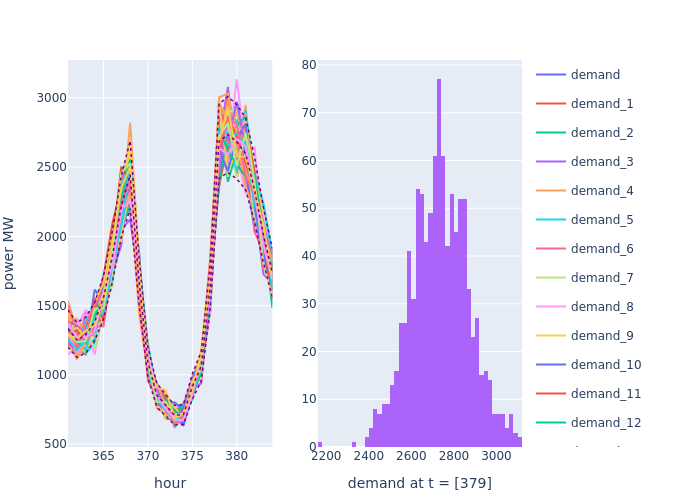

In [8]:
select_first = 100
to_plot_demand = stack(random_loads_multi_df[!,1:(select_first+1)], Not(:hour))
# to_plot_demand = s_ed.demand[s_ed.demand.day .== days[get_day],:]
to_plot_reserve = copy(required_reserve)
to_plot_reserve.reserve_up_MW = required_reserve.reserve_up_MW .+ loads_multi_df.demand
to_plot_reserve.reserve_down_MW = -required_reserve.reserve_down_MW .+ loads_multi_df.demand
to_plot_reserve.demand_MW = loads_multi_df.demand
to_plot_reserve = stack(to_plot_reserve, Not(:hour))
s= scatter(to_plot_demand, x = :hour, y = :value, group = :variable)
s1 = scatter(to_plot_reserve, x = :hour, y = :value, group = :variable, line=attr(color="purple", width=1.5, dash="dot"))
union!(s,s1)
p1 = plot(s, Layout(yaxis_title="power MW", xaxis_title="hour"))

t_ = loads_multi_df[loads_multi_df.demand .== maximum(loads_multi_df.demand),:hour]
to_plot_histogram = stack(random_loads_multi_df[random_loads_multi_df.hour .== t_, :])
p2 = plot(to_plot_histogram, x = :value, kind="histogram", histonorm = "percent", Layout(xaxis_title_text="demand at t = $t_"))

[p1 p2]

In [9]:
thres =.1
f_LOL(x,y) = 
    (LOL_hours=count(x.>thres),
    LOLP=count(x.>thres)/count(y.>=thres)*100,
    LOL_MW = sum(x),
    LOL_percentage = sum(x)/sum(y)*100,
    Demand_MWh = sum(y),
    )
f_CUR(x,y) =     
    (CUR_hours=count(x.>thres*y.>thres),
    CURP=count(x.>thres)/count(y.>=0)*100,
    CUR_MW = sum(x),
    CUR_percentage = sum(x)/sum(y)*100,
    RES_generation_MWh = sum(y),
    )
    

f_CUR (generic function with 1 method)

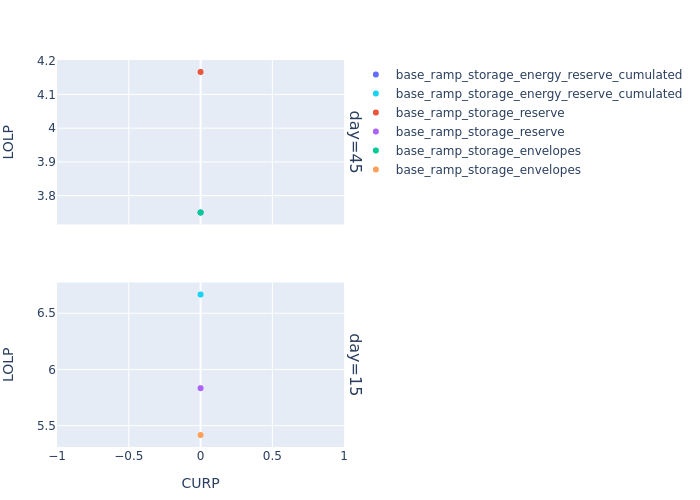

In [10]:
group_by = [:configuration, :day]
LOL = combine(groupby(s_ed.demand, group_by), [:LOL_MW, :demand_MW] => ((x,y)->f_LOL(x,y)) => AsTable)
filter = in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic", "net_generation"]).(s_ed.generation.resource)
CUR = combine(groupby(s_ed.generation[filter,:], group_by), [:curtailment_MW, :production_MW] =>((x,y) -> f_CUR(x,y))=> AsTable)
LOL_CUR = outerjoin(LOL, CUR, on=[:configuration, :day])
plot(LOL_CUR, x = :CURP, y = :LOLP, group = :configuration, facet_row = :day, mode="markers")

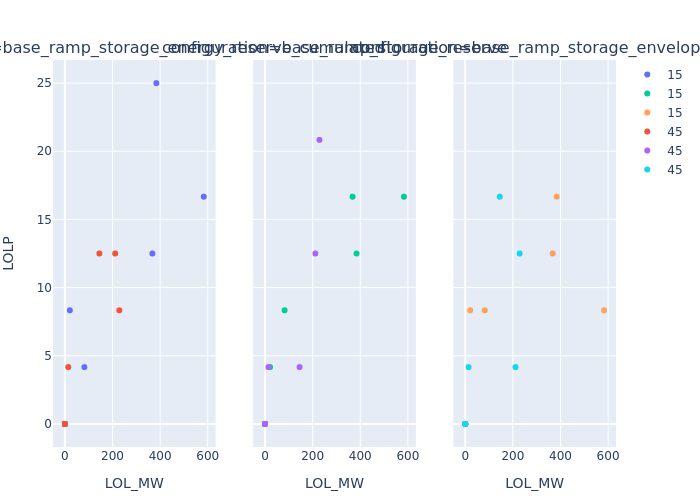

In [11]:
gdf_LOL = combine(groupby(s_ed.demand, union([:iteration], group_by)), [:LOL_MW, :demand_MW] => ((x,y)->f_LOL(x,y)) => AsTable)
plot(gdf_LOL, y = :LOLP, x = :LOL_MW, facet_col = :configuration, group = :day, mode="markers")

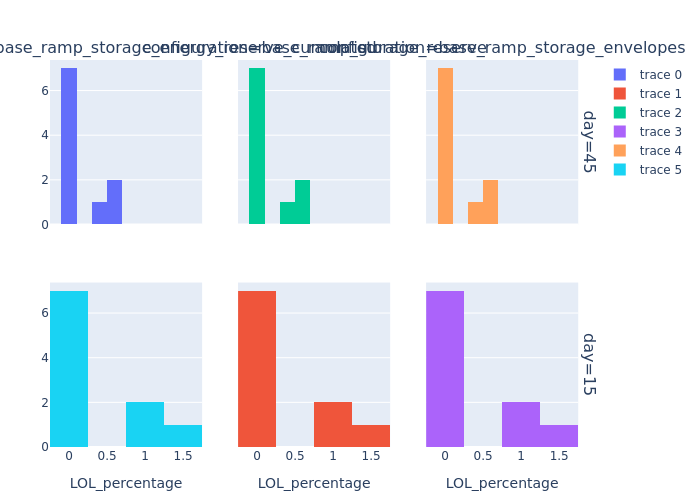

In [12]:
plot(gdf_LOL, x = :LOL_percentage, kind="histogram", facet_col = :configuration, facet_row = :day, histonorm = "percent")

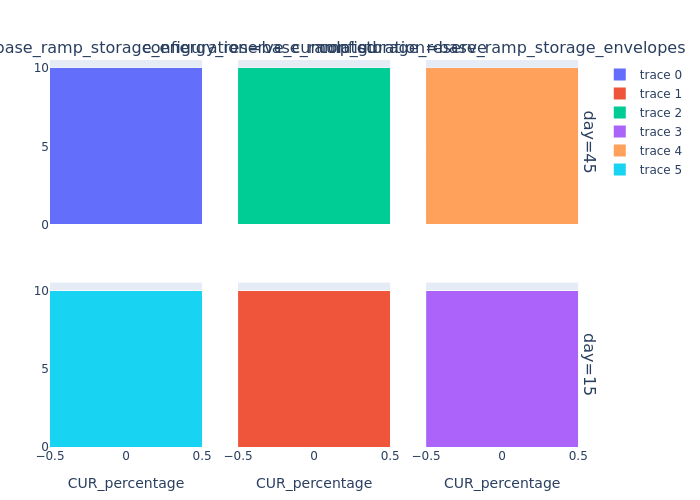

In [13]:
filter = in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(s_ed.generation.resource) 
gdf_CUR = combine(groupby(s_ed.generation[filter,:], union([:iteration], group_by)), [:curtailment_MW, :production_MW] =>((x,y) -> f_CUR(x,y))=> AsTable)
plot(gdf_CUR, x = :CUR_percentage, kind="histogram", facet_col = :configuration, facet_row = :day, histonorm = "percent")

In [41]:
# CSV.write("gdf_LOL.csv",gdf_LOL)
# CSV.write("gdf_CUR.csv",gdf_CUR)

"gdf_CUR.csv"

In [39]:
supply_uc, demand_uc = calculate_supply_demand(s_uc, union([:hour, :resource], group_by))
supply_ed, demand_ed = calculate_supply_demand(s_ed, union([:hour, :resource, :iteration], group_by))
;

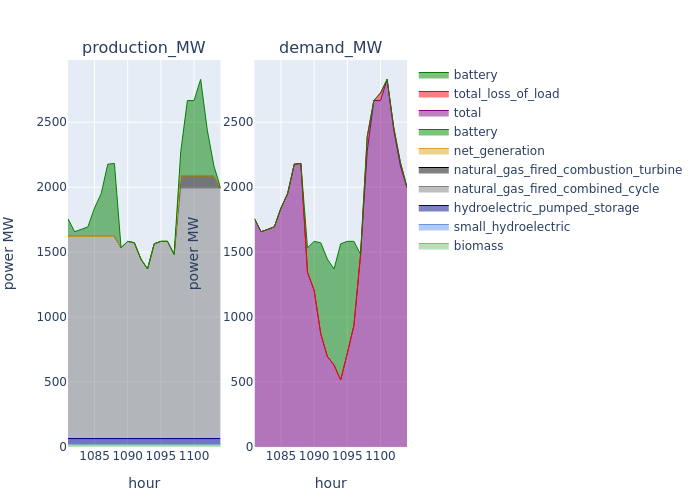

In [40]:
config_ = :base_ramp_storage_reserve
day_ = 45
iteration_ = :demand_6
supply_ed_ = supply_ed[(supply_ed.configuration .== config_) .& (supply_ed.day .== day_) .& (supply_ed.iteration .== iteration_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== config_) .& (demand_ed.day .== day_) .& (demand_ed.iteration .== iteration_), :]
plot_supply_demand(supply_ed_, demand_ed_)


In [38]:
unique(demand_ed_.resource)

3-element Vector{Union{Missing, String}}:
 "total_loss_of_load"
 "total"
 "battery"

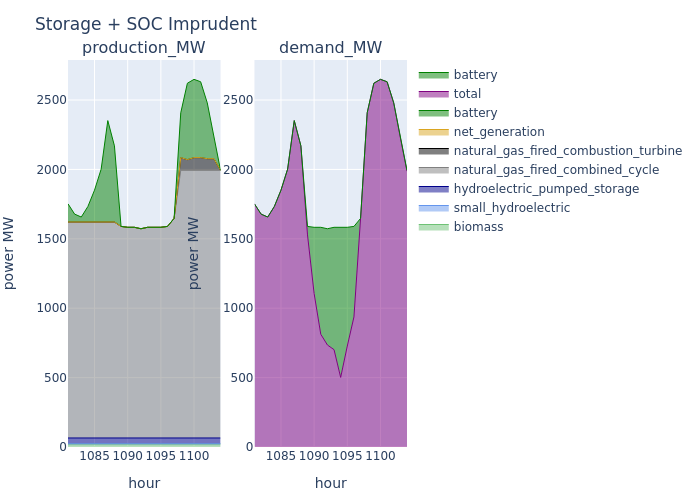

In [18]:
# config_ = :base_ramp_storage_reserve
# day_ = 15
# filter = ()
supply_ = supply_uc[(supply_uc.configuration .== config_) .& (supply_uc.day .== day_), :]
demand_ = demand_uc[(demand_uc.configuration .== config_) .& (demand_uc.day .== day_), :]
solution_reserve_ = s_uc.reserve[(s_uc.reserve.configuration .== config_) .& (s_uc.reserve.day .== day_), :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + SOC Imprudent")

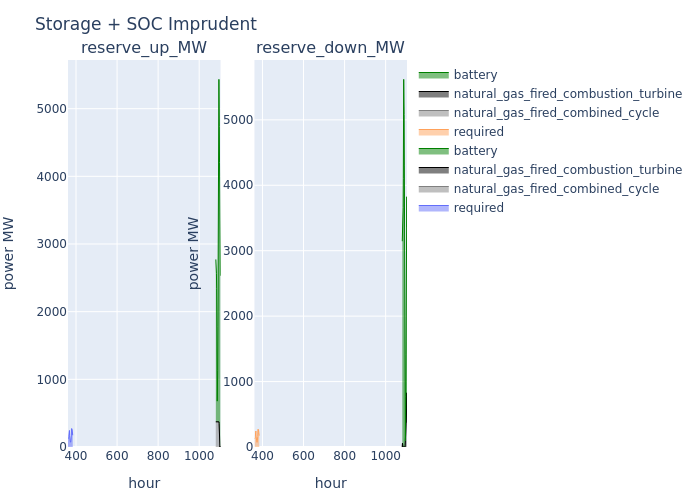

In [19]:
plot_reserve(reserve_, "Storage + SOC Imprudent")

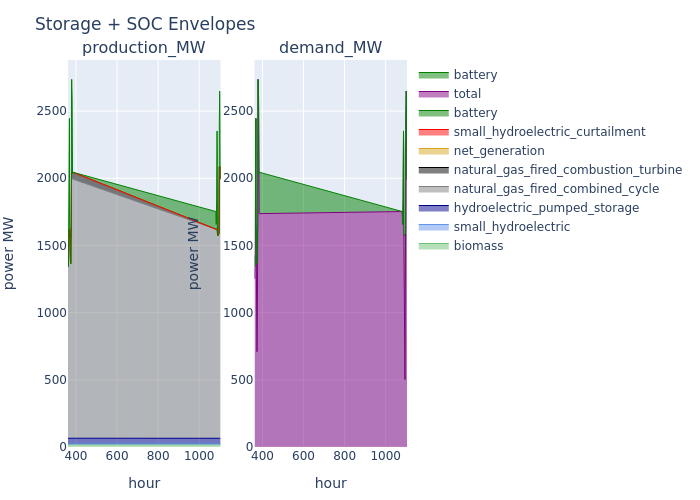

In [21]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_envelopes, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_envelopes, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_envelopes, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + SOC Envelopes")

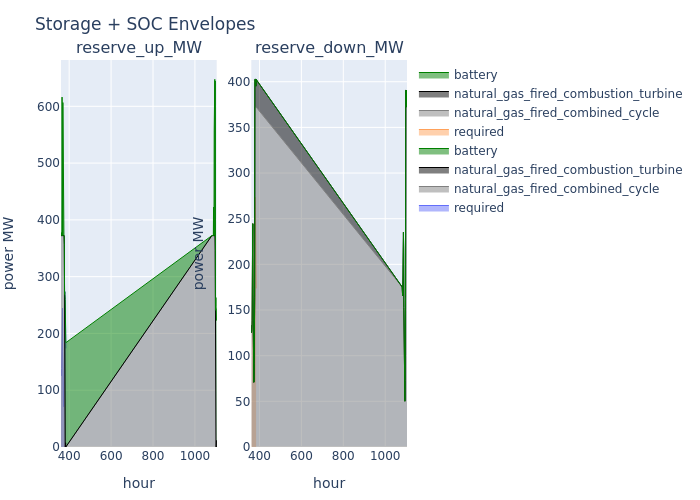

In [22]:
plot_reserve(reserve_, "Storage + SOC Envelopes")

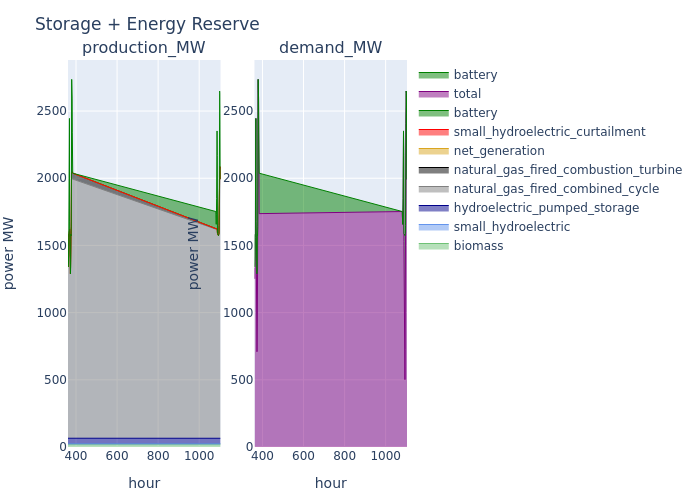

In [23]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + Energy Reserve")

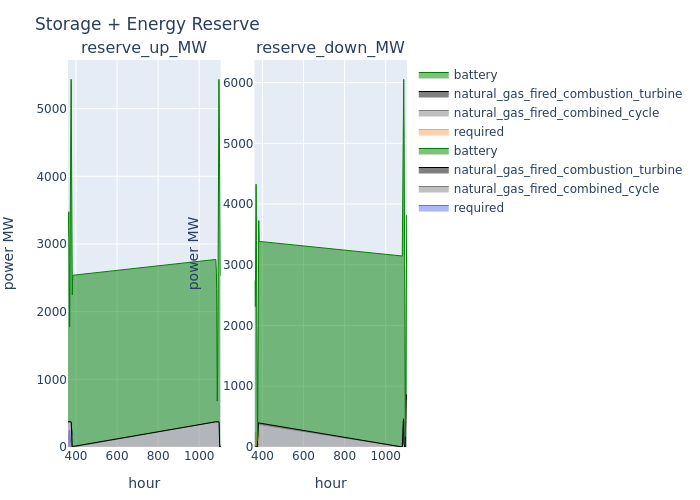

In [24]:
plot_reserve(reserve_, "Storage + Energy Reserve")

## Other

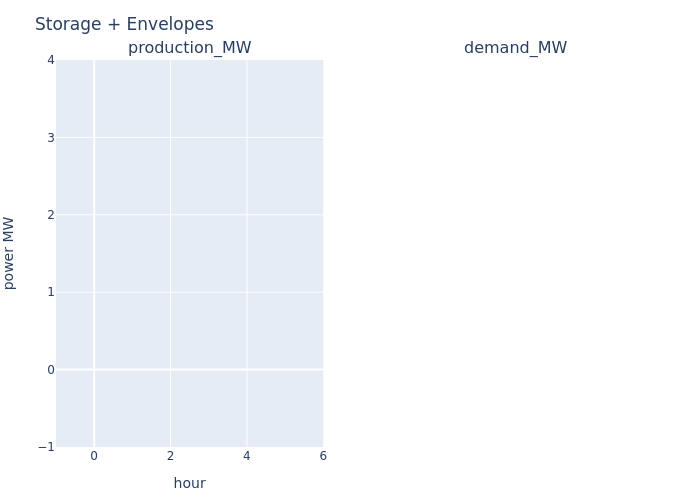

In [26]:
demand_ = :demand_28
supply_ed_ = supply_ed[(supply_ed.configuration .== :base_ramp_storage_envelopes).&(supply_ed.iteration .== demand_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== :base_ramp_storage_envelopes).&(demand_ed.iteration .== demand_), :]
# solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_envelopes, :]
# reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_ed_, demand_ed_,"Storage + Envelopes")
# p1 = plot_fieldx_by_fieldy(supply_ed_, :production_MW, :resource, "ED - Storage + SOC Envelopes")

# p2 = plot_fieldx_by_fieldy(supply_ed_, :production_MW, :resource, "ED - Storage + Energy Reserve")

# [p1 p2]

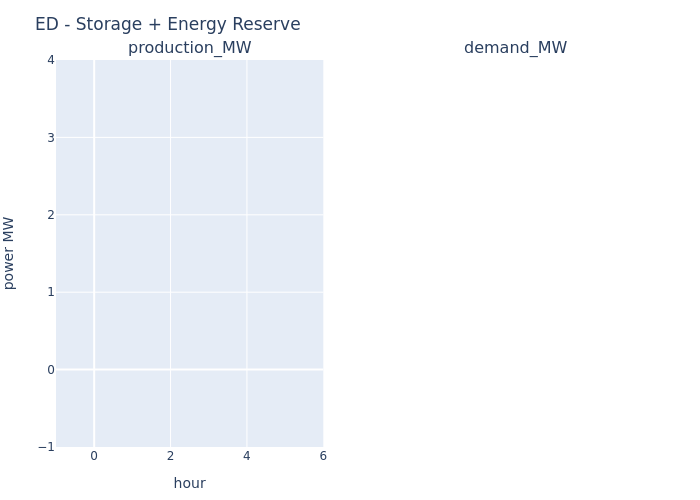

In [27]:
supply_ed_ = supply_ed[(supply_ed.configuration .== :base_ramp_storage_energy_reserve_cumulated).&(supply_ed.iteration .== demand_), :]
demand_ed_ = demand_ed[(demand_ed.configuration .== :base_ramp_storage_energy_reserve_cumulated).&(demand_ed.iteration .== demand_), :]
plot_supply_demand(supply_ed_, demand_ed_,"ED - Storage + Energy Reserve")

In [28]:
gdf_LOL

Row,iteration,configuration,day,LOL_hours,LOLP,LOL_MW,LOL_percentage,Demand_MWh
,Symbol,Symbol,Int64,Int64,Float64,Float64,Float64,Float64
1,demand_7,base_ramp_storage_energy_reserve_cumulated,45,3,12.5,211.324,0.509961,41439.3
2,demand_6,base_ramp_storage_energy_reserve_cumulated,45,2,8.33333,228.606,0.566202,40375.3
3,demand_8,base_ramp_storage_energy_reserve_cumulated,45,0,0.0,0.0,0.0,39804.7
4,demand_1,base_ramp_storage_energy_reserve_cumulated,45,0,0.0,0.0,0.0,40502.6
5,demand_4,base_ramp_storage_energy_reserve_cumulated,45,3,12.5,144.94,0.355773,40739.4
6,demand_2,base_ramp_storage_energy_reserve_cumulated,45,1,4.16667,14.1308,0.0344614,41004.6
7,demand_9,base_ramp_storage_energy_reserve_cumulated,45,0,0.0,0.0,0.0,40206.3
8,demand,base_ramp_storage_energy_reserve_cumulated,45,0,0.0,0.0,0.0,40893.3
9,demand_3,base_ramp_storage_energy_reserve_cumulated,45,0,0.0,0.0,0.0,39843.1
